In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import torch.nn.functional as F
import time

In [2]:
import torch.nn.init as init
import math

In [3]:
# # Load the CIFAR-10 dataset with data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the training set into train and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Create dataloaders
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size= 100, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size= 100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 28243442.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [29]:
# List of classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for ResNet architecture

    This class implements a basic residual block used in ResNet architectures.

    Attributes:
        expansion (int): The factor by which the number of output channels
                         is increased in the residual function. Default is 1.

    """

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes a BasicBlock object.

        Args:
            in_channels (int): The number of input channels.
            out_channels (int): The number of output channels.
            stride (int, optional): The stride for the first convolutional layer
                                    of the residual function. Default is 1.
        """
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        """
        Defines the forward pass of the BasicBlock.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor of the BasicBlock.
        """
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
        
class ResNet(nn.Module):
    """ResNet architecture

    This class implements the ResNet architecture for image classification.

    Attributes:
        in_channels (int): The number of input channels.
        conv1 (nn.Sequential): The first convolutional layer.
        conv2_x (nn.Sequential): The second convolutional layer.
        conv3_x (nn.Sequential): The third convolutional layer.
        conv4_x (nn.Sequential): The fourth convolutional layer.
        conv5_x (nn.Sequential): The fifth convolutional layer.
        avg_pool (nn.AdaptiveAvgPool2d): The adaptive average pooling layer.
        fc (nn.Linear): The fully connected classification layer.
    """

    def __init__(self, block, num_blocks, num_classes=100):
        """
        Initializes a ResNet object.

        Args:
            block (nn.Module): The type of residual block to use.
            num_blocks (list[int]): A list of integers specifying how many
                                    blocks to use in each layer.
            num_classes (int, optional): The number of output classes.
                                         Default is 100.
        """
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_blocks[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_blocks[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_blocks[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_blocks[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers

        This method creates a layer in the ResNet architecture, which consists
        of multiple residual blocks.

        Args:
            block (nn.Module): The type of residual block to use.
            out_channels (int): The number of output channels for the layer.
            num_blocks (int): The number of residual blocks in the layer.
            stride (int): The stride for the first block of the layer.

        Returns:
            nn.Sequential: A sequence of residual blocks forming a layer.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Defines the forward pass of the ResNet architecture.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor of the ResNet architecture.
        """
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output



In [10]:
# Initialize lists for storing training and testing data
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Function for training
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total, total, correct

# Function for testing
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total, total, correct

In [11]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/resnet18_cifar10v_1'
writer = SummaryWriter(log_dir)

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet model
num_classes = 10
resnet18_model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

print(resnet18_model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [13]:
# Train the model
num_epochs = 30
resnet18_train_losses = []
resnet18_train_accs = []
resnet18_val_losses = []
resnet18_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(resnet18_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(resnet18_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    resnet18_train_losses.append(train_loss)
    resnet18_train_accs.append(train_acc)
    resnet18_val_losses.append(val_loss)
    resnet18_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

Testing Accuracy: 51.45%
Epoch [1/30], Train Loss: 1.5802, Train Acc: 43.23, Val Loss: 1.4113, Val Acc: 51.45
Testing Accuracy: 58.59%
Epoch [2/30], Train Loss: 1.1201, Train Acc: 60.02, Val Loss: 1.1523, Val Acc: 58.59
Testing Accuracy: 61.77%
Epoch [3/30], Train Loss: 0.9166, Train Acc: 67.64, Val Loss: 1.1061, Val Acc: 61.77
Testing Accuracy: 70.24%
Epoch [4/30], Train Loss: 0.7806, Train Acc: 72.48, Val Loss: 0.8554, Val Acc: 70.24
Testing Accuracy: 71.49%
Epoch [5/30], Train Loss: 0.7043, Train Acc: 75.17, Val Loss: 0.8490, Val Acc: 71.49
Testing Accuracy: 76.24%
Epoch [6/30], Train Loss: 0.6362, Train Acc: 77.72, Val Loss: 0.6975, Val Acc: 76.24
Testing Accuracy: 77.32%
Epoch [7/30], Train Loss: 0.5850, Train Acc: 79.44, Val Loss: 0.6745, Val Acc: 77.32
Testing Accuracy: 79.84%
Epoch [8/30], Train Loss: 0.5492, Train Acc: 80.92, Val Loss: 0.5957, Val Acc: 79.84
Testing Accuracy: 79.44%
Epoch [9/30], Train Loss: 0.5095, Train Acc: 82.06, Val Loss: 0.6097, Val Acc: 79.44
Testing Ac

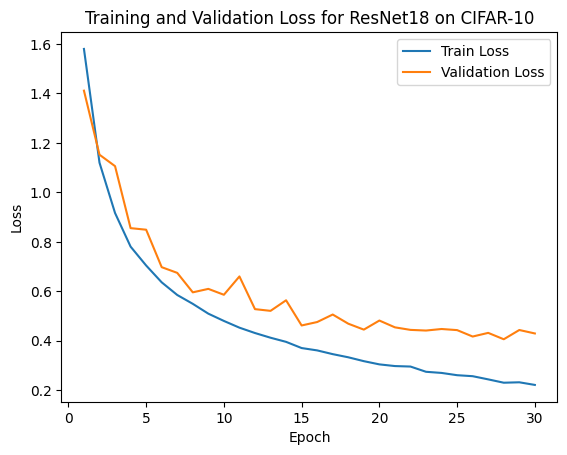

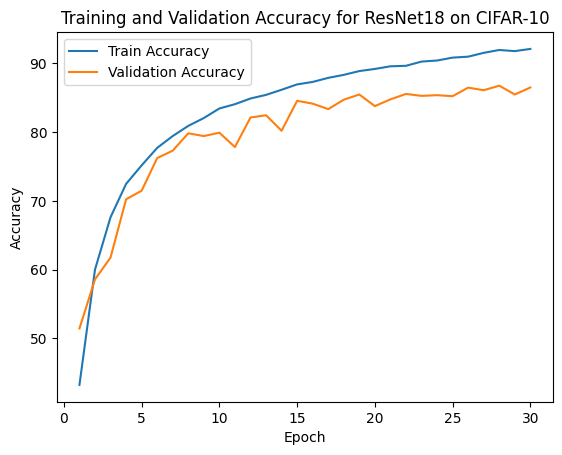

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet18_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), resnet18_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for ResNet18 on CIFAR-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet18_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet18_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for ResNet18 on CIFAR-10')
plt.show()

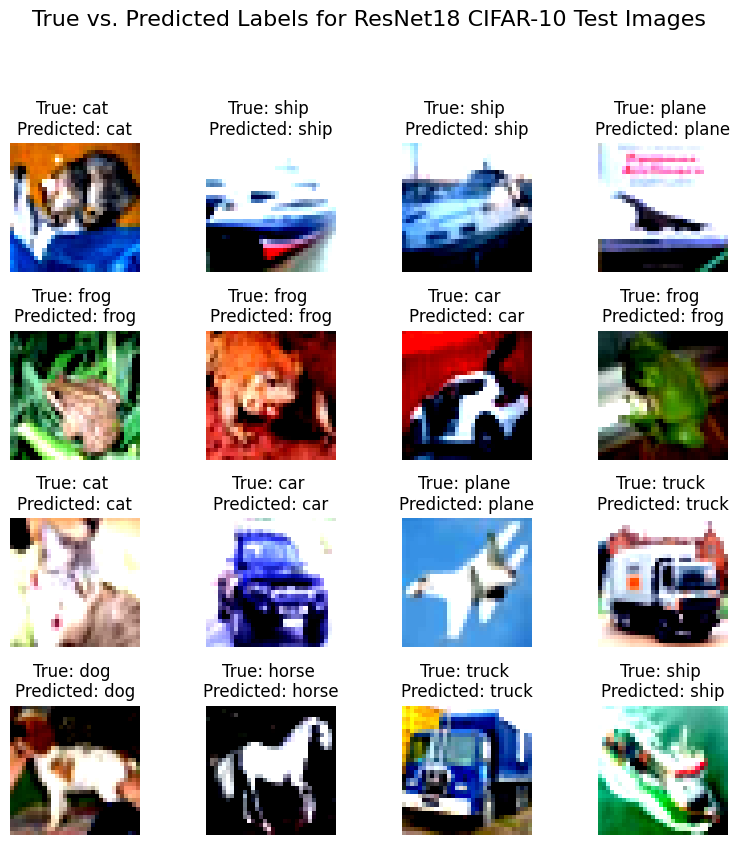

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(resnet18_model, test_loader)
plt.suptitle('True vs. Predicted Labels for ResNet18 CIFAR-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [16]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/resnet34_cifar10v_1'
writer = SummaryWriter(log_dir)

In [17]:
# Initialize the ResNet model
num_classes = 10
resnet34_model = ResNet(BasicBlock, [3, 4, 6, 3]).to(device)

print(resnet34_model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [18]:
# Train the model
num_epochs = 30
resnet34_train_losses = []
resnet34_train_accs = []
resnet34_val_losses = []
resnet34_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(resnet34_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(resnet34_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    resnet34_train_losses.append(train_loss)
    resnet34_train_accs.append(train_acc)
    resnet34_val_losses.append(val_loss)
    resnet34_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

Testing Accuracy: 51.11%
Epoch [1/30], Train Loss: 1.6573, Train Acc: 39.77, Val Loss: 1.3468, Val Acc: 51.11
Testing Accuracy: 55.07%
Epoch [2/30], Train Loss: 1.2078, Train Acc: 56.74, Val Loss: 1.3560, Val Acc: 55.07
Testing Accuracy: 68.29%
Epoch [3/30], Train Loss: 0.9826, Train Acc: 65.20, Val Loss: 0.9070, Val Acc: 68.29
Testing Accuracy: 68.85%
Epoch [4/30], Train Loss: 0.8247, Train Acc: 70.80, Val Loss: 0.9166, Val Acc: 68.85
Testing Accuracy: 73.65%
Epoch [5/30], Train Loss: 0.7318, Train Acc: 74.61, Val Loss: 0.7702, Val Acc: 73.65
Testing Accuracy: 73.01%
Epoch [6/30], Train Loss: 0.6610, Train Acc: 76.86, Val Loss: 0.7885, Val Acc: 73.01
Testing Accuracy: 75.5%
Epoch [7/30], Train Loss: 0.6075, Train Acc: 79.03, Val Loss: 0.7305, Val Acc: 75.50
Testing Accuracy: 78.42%
Epoch [8/30], Train Loss: 0.5673, Train Acc: 80.39, Val Loss: 0.6324, Val Acc: 78.42
Testing Accuracy: 77.14%
Epoch [9/30], Train Loss: 0.5230, Train Acc: 81.96, Val Loss: 0.6867, Val Acc: 77.14
Testing Acc

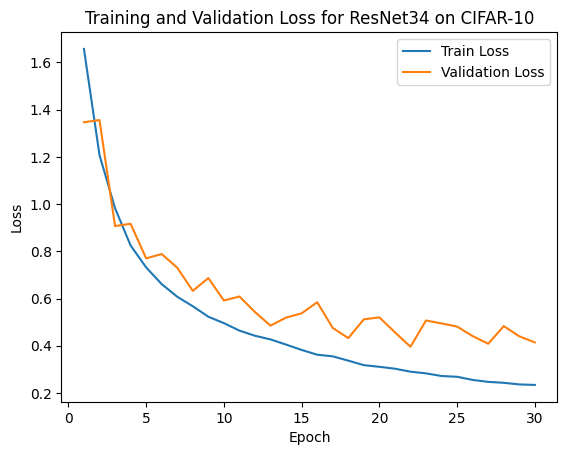

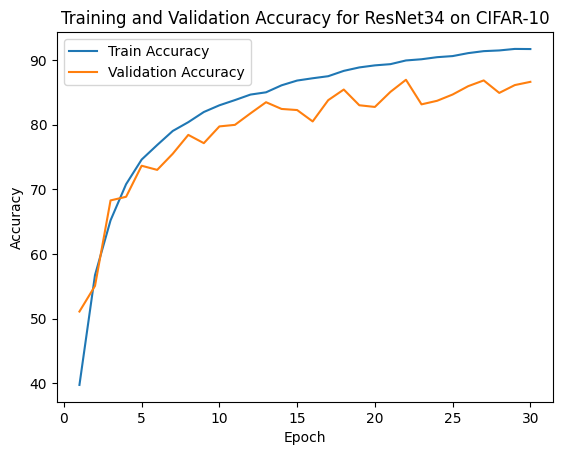

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet34_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), resnet34_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for ResNet34 on CIFAR-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet34_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet34_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for ResNet34 on CIFAR-10')
plt.show()

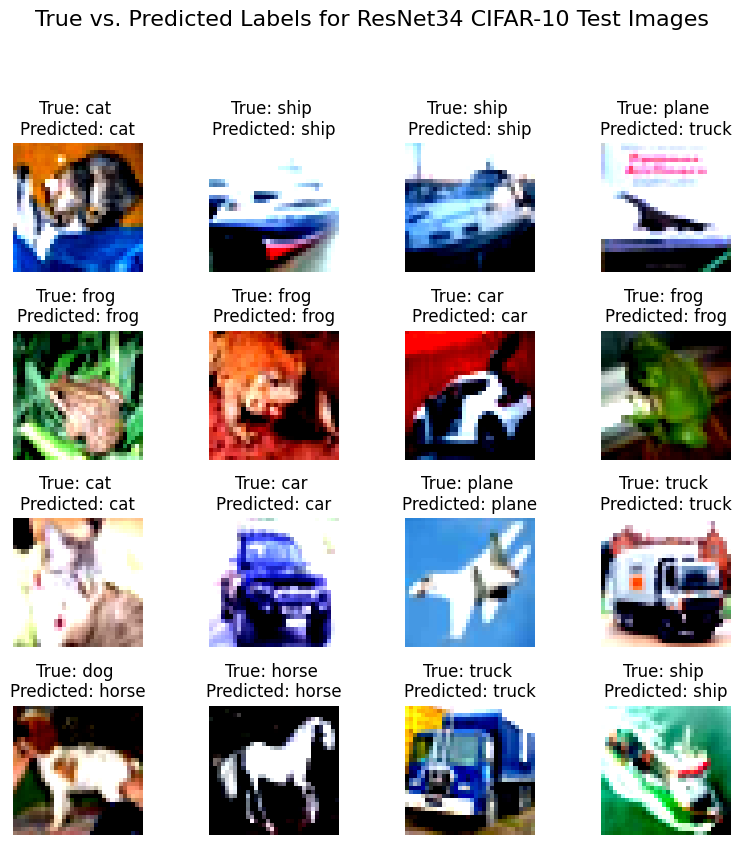

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(resnet34_model, test_loader)
plt.suptitle('True vs. Predicted Labels for ResNet34 CIFAR-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [21]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/resnet50_cifar10v_1'
writer = SummaryWriter(log_dir)

In [22]:
# Initialize the ResNet model
num_classes = 10
resnet50_model = ResNet(BottleNeck, [3, 4, 6, 3]).to(device)

print(resnet34_model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [23]:
# Train the model
num_epochs = 30
resnet50_train_losses = []
resnet50_train_accs = []
resnet50_val_losses = []
resnet50_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(resnet50_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(resnet50_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    resnet50_train_losses.append(train_loss)
    resnet50_train_accs.append(train_acc)
    resnet50_val_losses.append(val_loss)
    resnet50_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

Testing Accuracy: 42.46%
Epoch [1/30], Train Loss: 1.9203, Train Acc: 31.68, Val Loss: 1.6185, Val Acc: 42.46
Testing Accuracy: 51.91%
Epoch [2/30], Train Loss: 1.3899, Train Acc: 49.56, Val Loss: 1.3241, Val Acc: 51.91
Testing Accuracy: 61.53%
Epoch [3/30], Train Loss: 1.1700, Train Acc: 57.88, Val Loss: 1.0854, Val Acc: 61.53
Testing Accuracy: 64.22%
Epoch [4/30], Train Loss: 1.0064, Train Acc: 64.33, Val Loss: 1.0456, Val Acc: 64.22
Testing Accuracy: 70.22%
Epoch [5/30], Train Loss: 0.8880, Train Acc: 68.50, Val Loss: 0.8579, Val Acc: 70.22
Testing Accuracy: 71.27%
Epoch [6/30], Train Loss: 0.7842, Train Acc: 72.60, Val Loss: 0.8263, Val Acc: 71.27
Testing Accuracy: 72.87%
Epoch [7/30], Train Loss: 0.7014, Train Acc: 75.45, Val Loss: 0.8353, Val Acc: 72.87
Testing Accuracy: 72.73%
Epoch [8/30], Train Loss: 0.6365, Train Acc: 77.70, Val Loss: 0.8397, Val Acc: 72.73
Testing Accuracy: 76.29%
Epoch [9/30], Train Loss: 0.5831, Train Acc: 79.78, Val Loss: 0.6979, Val Acc: 76.29
Testing Ac

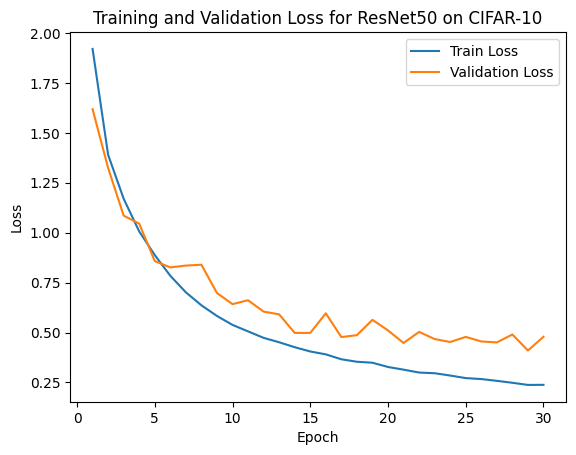

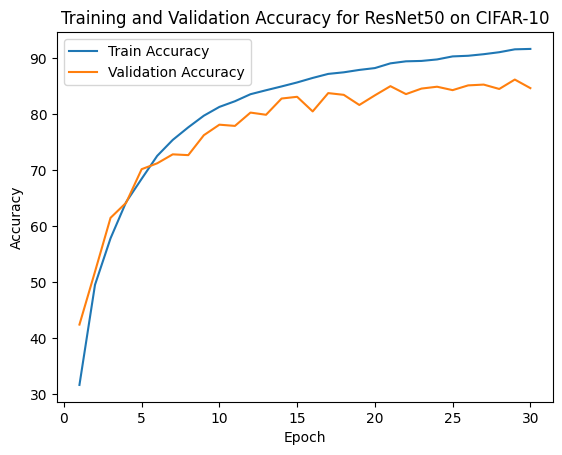

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet50_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), resnet50_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for ResNet50 on CIFAR-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet50_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet50_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for ResNet50 on CIFAR-10')
plt.show()

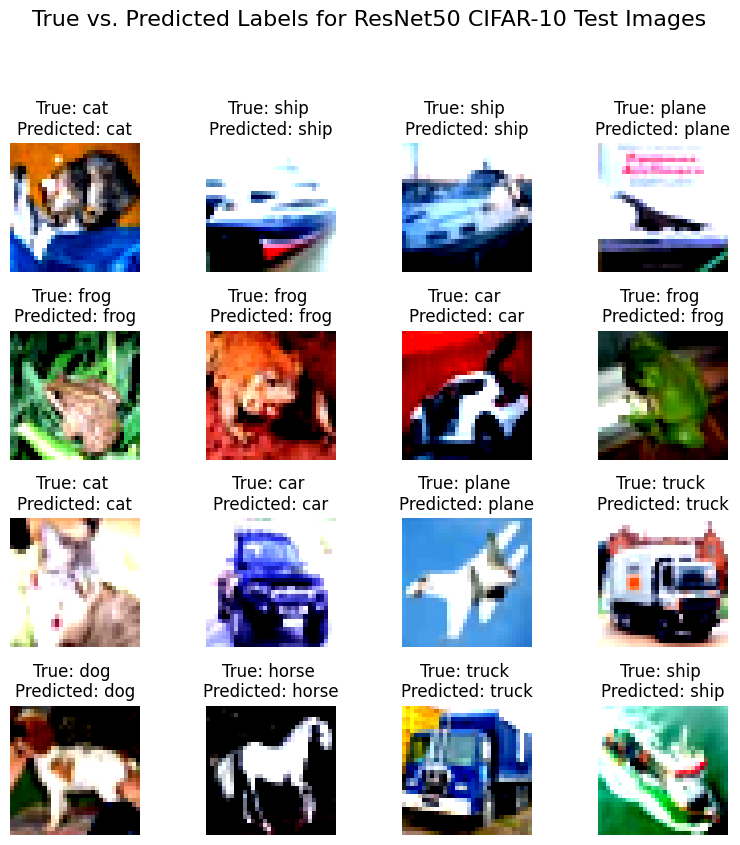

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(resnet50_model, test_loader)
plt.suptitle('True vs. Predicted Labels for ResNet50 CIFAR-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

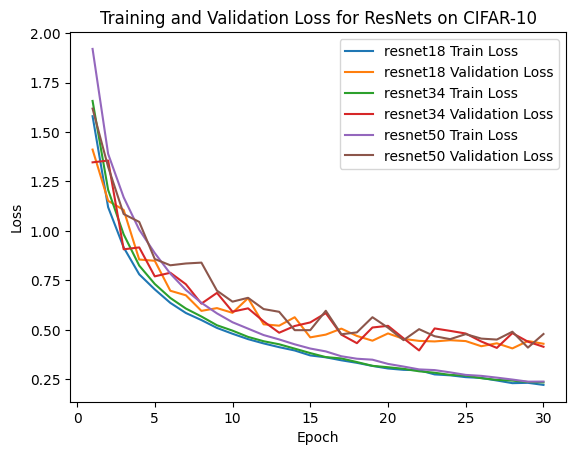

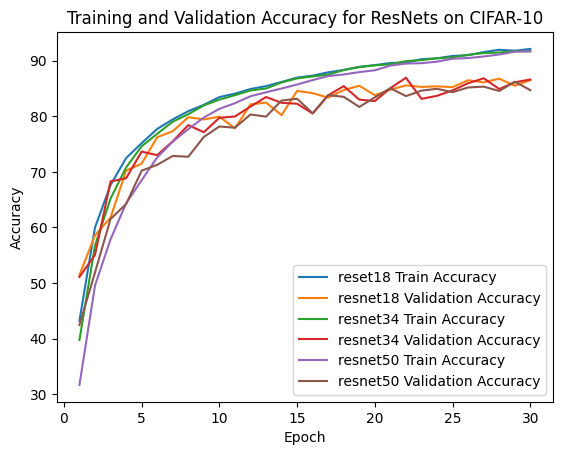

In [26]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet18_train_losses, label='resnet18 Train Loss')
plt.plot(range(1, num_epochs + 1), resnet18_val_losses, label='resnet18 Validation Loss')
plt.plot(range(1, num_epochs + 1), resnet34_train_losses, label='resnet34 Train Loss')
plt.plot(range(1, num_epochs + 1), resnet34_val_losses, label='resnet34 Validation Loss')
plt.plot(range(1, num_epochs + 1), resnet50_train_losses, label='resnet50 Train Loss')
plt.plot(range(1, num_epochs + 1), resnet50_val_losses, label='resnet50 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for ResNets on CIFAR-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), resnet18_train_accs, label='reset18 Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet18_val_accs, label='resnet18 Validation Accuracy')
plt.plot(range(1, num_epochs + 1), resnet34_train_accs, label='resnet34 Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet34_val_accs, label='resnet34 Validation Accuracy')
plt.plot(range(1, num_epochs + 1), resnet50_train_accs, label='resnet50 Train Accuracy')
plt.plot(range(1, num_epochs + 1), resnet50_val_accs, label='resnet50 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for ResNets on CIFAR-10')
plt.show()

In [27]:
!kill 19942

/bin/bash: line 0: kill: (19942) - No such process


In [28]:
%reload_ext tensorboard

%tensorboard --logdir runs

<IPython.core.display.Javascript object>